# ACSE4 2020 Machine Learning Mini-project ------- X-Ray Classification 
<hr>

## Group : MaxPool

*This notebook collects all the models we have tested during the project.*

# Prepare the data
***If you want to run the following model by yourself, you should following the cells in this part.***

***If you only want to see the reslts, you could click*** 
[here](#Models) 
***to skip this part and check our plots in each model.***

## Getting Started

You will need to register for a Google Account (Make a throwaway account if you do not want google to have your data).  

Register on the Kaggle Platform (required for Mini-Project): [Link](https://www.kaggle.com)


## Data gathering

You can use google drive to store and access files, e.g the photo data, model data or CSV files.  
Use the following command to mount your GDrive and access your files.

The dataset was downloaded from Kaggle (https://www.kaggle.com/c/acse4-ml-2020/data) where it was already divided into two initial sets in xray-data folders (train , test). The train folder contain four sub-folders(covid, lung_opacity,normal and pneumonia) where the X-ray images have been already labeled. The test folder only has images without labels

At first, we don't know how many x-rays images have been allocated per set/folder, therefore, the first thing to do is to set up the location of the main directory so that these images can be accessed, followed by a quick review of it's content, meaning how many images have been allocated in each sub-set/folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

### Using the GPU

Google Colab enables us to obtain free GPU computing resources.  
You can switch the runtime of Google Colab from CPU to GPU based via the ```toolbar```:  

Commands:
```Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU```

In [ ]:
import torch

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

### Download data 

You could download the data by hand on [Link](https://www.kaggle.com/c/acse4-ml-2020/data), or using the following method to directly grab the data from Kaggle to Google Drive.


#### Upload `kaggle.json`, and authorization

Generate a kaggle api from your Kaggle user profile. Enter your kaggle user profile, like https://www.kaggle.com/{username}, generate a `kaggle.json` by clicking "create new API token".

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive")

# upload kaggle.json 
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Download Zip file of the dataset

In [ ]:
!kaggle competitions download -c acse4-ml-2020 -p /content/gdrive/My\ Drive/acse4

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/acse4")
!ls

#### Import packages, unzip data to working dir

In [ ]:
!unzip acse4-ml-2020.zip -d "/content/sample_data/"

In [ ]:
# change path to sample_data
os.chdir("/content/sample_data")   

### Library

In [ ]:
!pip install pycm livelossplot
%pylab inline

In [ ]:
import random
import re
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset, Dataset
from torch.utils.data import random_split, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

import torchvision.transforms as tt
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision.datasets import ImageFolder 
import cv2


from glob import glob


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

Get the path for our training data and test data, also we create one more "test" folder inside the "./test" folder, which is useful for the implmentation of the `ImageFolder` function.

In [ ]:
# define the different folder pathes
data_directory = os.listdir('./xray-data/')
data_dir = "./xray-data/xray-data/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")

In [ ]:
!cd ./xray-data/xray-data/test && mkdir test

In [ ]:
!mv ./xray-data/xray-data/test/* ./xray-data/xray-data/test/test

mv: cannot move './xray-data/xray-data/test/test' to a subdirectory of itself, './xray-data/xray-data/test/test/test'


## Preprocessing data:

Before we continue, we shold load all the image files, so we will use ImageFolder to complete this task.

Here we crop the image into 224*224. The reasons are as follow:

1. Large image take up more memory.

2. Entering a smaller size image will not affect our learning of lung features.(check by **visualize the image** part)

*Note that we need to crop the image into 190$\times$190 to run the ResNet50 Model.*

In [ ]:
# Generate Datasets from `./train` and `./test` folder, quite handy to use `ImageFolder`, 
# we also perform a centercrop to reshape the picture to 224 * 224 for a initial data augmentation:
# create the augmentation for initialize the training and testing data
init_transform = tt.Compose([
    tt.CenterCrop((224, 224)),   # resieze the pictures
])

In [ ]:
# get the data from train folder and test folder
train_data = ImageFolder(train_dir, init_transform)
test_data  = ImageFolder(test_dir, init_transform)

### Prepare the Dataset

Different labels correspond to different numbers, and the initial corresponding results are as follows

#### Different labels

In [ ]:
train_data.class_to_idx

Note the `imageFolder` has a wrong key for "normal" and "pneumonia", they should be swapped:

In [ ]:
train_data.targets = np.array(train_data.targets)
temp = copy.deepcopy(train_data.targets)

# swap targets
train_data.targets[temp == 2] = 3
train_data.targets[temp == 3] = 2

In [ ]:
# get the number of each folder's pictures
print('Number of X-rays classified as covid:', len(train_data.targets[train_data.targets == 0]))
print('Number of X-rays classified as lung_opacity:', len(train_data.targets[train_data.targets == 1]))
print('Number of X-rays classified as pneumonia:', len(train_data.targets[train_data.targets == 2])) # Number of x-rays classified as 'PNEUMONIA'
print('Number of X-rays classified as normal:', len(train_data.targets[train_data.targets == 3]))
print('Total number of Train X-rays:', len(train_data.targets),'\n')

print('Total number of Test X-rays:', len(test_data.targets))

Number of X-rays classified as covid: 3454
Number of X-rays classified as lung_opacity: 5742
Number of X-rays classified as pneumonia: 1285
Number of X-rays classified as normal: 9734
Total number of Train X-rays: 20215 

Total number of Test X-rays: 950


#### Visualize the image

In [ ]:
def show_batch(dataset, nr=4, nc=4):
    fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset))
            sample, target = dataset[idx]
            try:
                axarr[i][j].imshow(sample) # if PIL
            except:
                axarr[i][j].imshow(sample.permute(1,2,0)) # if tensor of shape CHW
            target_name = dataset.classes[target]
            axarr[i][j].set_title("%s (%i)"%(target_name, target))

    fig.tight_layout(pad=1.5)
    plt.show()

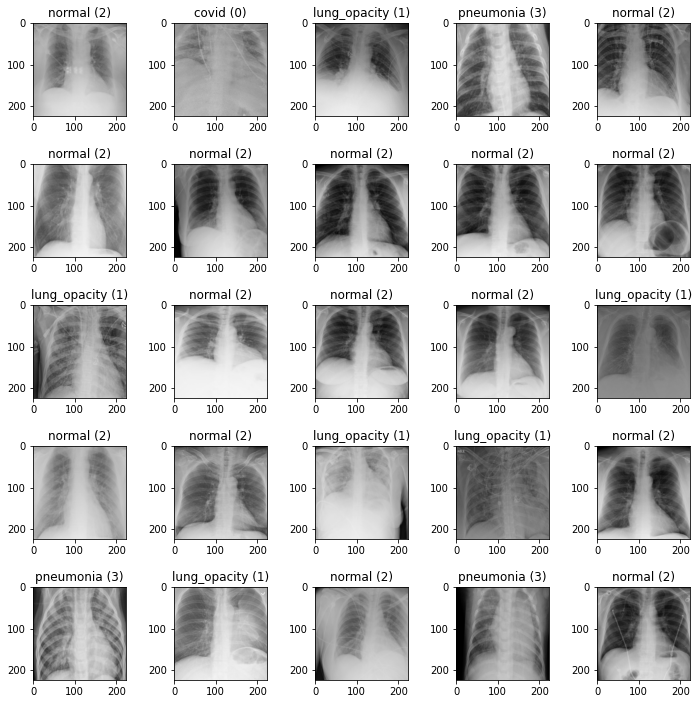

In [ ]:
show_batch(train_data, 5, 5)

#### Calculate the means and standard deviations

We should calculate the means and standard deviations for all of our training dataset, for Normalization. It will improve our accuracy

In [ ]:
# initialize means and stds(3 channel)
means = np.array([0] * 3, dtype = float)
stds = np.array([0] * 3, dtype = float)

In [ ]:
cnt_progress = 0
total = len(train_data)
bar=progressbar.ProgressBar(maxval=total)
for (img, _) in train_data:
    for i in range(3): 
        means[i] += np.mean(np.array(img).transpose([2, 0, 1])[i]) / 255
        stds[i] += np.std(np.array(img).transpose([2, 0, 1])[i]) / 255

    cnt_progress+=1
    bar.update(cnt_progress)
bar.finish()
means /= total
stds /= total
print('means:', means)
print('stds:', stds)

100% (20215 of 20215) |##################| Elapsed Time: 0:01:06 Time:  0:01:06


means: [0.55006141 0.55006141 0.55006141]
stds: [0.17962446 0.17962446 0.17962446]


#### Change Labels (Dataset `MyDataset`)

Because the initial corresponding results are wrong at this task, We wrote a custom dataset `MyDataset` to swap the labels generated by`imageFolder` (2 <-> 3)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]

        if self.transform:
            x = self.transform(x)
            
        if y == 2:
            return x, 3
        elif y == 3:
            return x, 2
        else:
            return x, y
        
    def __len__(self):
        return len(self.subset)

#### Random split the train data

Becaue number of the images in train folder is too large, we can randomly select images in train folder. By calling `random_split` function to complete this task

In [ ]:
seed = 42
torch.manual_seed(seed);

split_ratio = 1  # this range is from 0 to 1. It defines 
# splite the 70% of all training data, if you want full, just enter 1
train_splite_num = int(len(train_data)*split_ratio)
train_ignore_num = len(train_data) - train_splite_num

train_splite, train_ignore = random_split(train_data, [train_splite_num, train_ignore_num])

test1_splite_num = int(len(train_ignore) * 0.05)
data_ignore_num = len(train_ignore) - test1_splite_num
test1_subDs, data_ignore = random_split(train_ignore, [test1_splite_num, data_ignore_num])

validation_num = int(len(train_splite)*0.1)
train_num = len(train_splite) - validation_num
train_subDs, validation_subDs = random_split(train_splite, [train_num, validation_num])

train_dataset_size = len(train_data)

print('Number of training:', len(train_subDs))
print('Number of validation:', len(validation_subDs))
print('Number of testing:', len(test1_subDs))

Number of training: 18194
Number of validation: 2021
Number of testing: 0


#### Define transformations

In [ ]:
# define the augmentation for initialize the training set and validation set
train_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.RandomHorizontalFlip(0.5),
    tt.CenterCrop((224, 224)), # resize the pictures
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

val_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])
test_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

In [ ]:
train_subDs = MyDataset(train_subDs, train_transform)
validation_subDs = MyDataset(validation_subDs, val_transform)
if split_ratio != 1:
    test1_subDs = MyDataset(test1_subDs, val_transform)

A image after normalization:

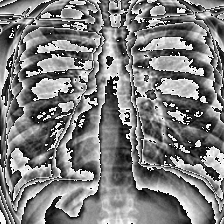

In [ ]:
tt.ToPILImage()(train_subDs[500][0])

Before normalization it looks like:

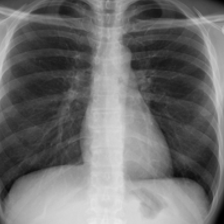

In [ ]:
train_subDs.subset.dataset[train_subDs.subset.indices[500]][0]

# <span id="Models">Models</span>

## Define functions
***You could also skip this part if you do not want to run the models by yourself.***

Here we define the functions we need to use when training the models.

In [ ]:
def train(model, optimizer, criterion, data_loader, accuracy_score_type = 'normal'):
    """
    Train the model with provided training data.
    ---
    model: the neutral network
    optimizer: it is used to update the weight parameters
    criterion: it is used to calculate the loss
    data_loader: the training dataloader
    accuracy_score_type: the default is normal, we can choose 'normal' or
                'f1_score' to compute accuracy_score or compute F1_score
    """
    model.train()   # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy, cnt_progress = 0, 0, 0  # initialise loss and accuracy to 0 for training
        
    for X, y in data_loader: # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
        optimizer.zero_grad()               # resetting optimiser info
        a2 = model(X.view(-1, 3, 224, 224))   # forward pass
        loss = criterion(a2, y)        # compute loss
        loss.backward()              # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)   # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions

        if accuracy_score_type == 'normal':
            # compute accuracy_score
            train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) 
        elif accuracy_score_type == 'f1_score':
            # compute F1_score
            train_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) 
        
    optimizer.step()  # perform a step of gradient descent
    cnt_progress += X.size(0)
    bar.update(cnt_progress)
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)   # here we can average over the whole dataset

# does not need optimiser
def validate(model, criterion, data_loader, accuracy_score_type = 'normal'):
    """
    Test the model with provided validation data.
    ---
    model: the neutral network
    optimizer: it is used to update the weight parameters
    criterion: it is used to calculate the loss
    data_loader: the training dataloader
    accuracy_score_type: the default is normal, we can choose 'normal' or
                'f1_score' to compute accuracy_score or compute F1_score
    """
    model.eval()            # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy, cnt_progress = 0, 0, bar.value # initialise loss and accuracy to 0 for training
    for X, y in data_loader:   # iterate over the mini-batches defined in the data loader
        with torch.no_grad():  # deactivates autograd engine
            X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 3, 224, 224))   # forward pass
            loss = criterion(a2, y)    # evaluate loss
            validation_loss += loss*X.size(0)    # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]   # get predictions
            if accuracy_score_type == 'normal':
                # compute accuracy_score
                validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) 
            elif accuracy_score_type == 'f1_score':
                # compute F1_score
                validation_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) 
                
            cnt_progress += X.size(0)
            bar.update(cnt_progress)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset
  
def evaluate_roc_auc_score(model, data_to_test):
    model = model.to(device)
    pred_matrix = np.zeros((len(data_to_test), 4))
    y_true = np.zeros(len(data_to_test))
    cnt_progress = 0
    bar=progressbar.ProgressBar(maxval=len(data_to_test))
    for i in range(len(data_to_test)):
        tensor = data_to_test[i][0].to(device)
        y_true[i] = data_to_test[i][1]
        tensor = tensor.reshape(1,3,224,224)
        out = model(tensor)
        y_pred_prob = F.softmax(out, dim=1)
        pred_matrix[i] = y_pred_prob.detach().cpu().numpy()
        cnt_progress+=1
        bar.update(cnt_progress)
    bar.finish()

    test_accuracy = roc_auc_score(y_true, np.array(pred_matrix), labels = np.array([0,1,2,3]), multi_class='ovr')
            
    return test_accuracy / len(data_to_test)  ## return the multi-class roc_auc_score

In [ ]:
def train_model(model, 
                momentum=0.5,
                betas=(0.9, 0.999),
                eps=1e-08,
                weight_decay=1e-2, 
                lr=1e-3, 
                n_epochs=10,
                epoch_start = 0, 
                batch_size=64, 
                test_batch_size=1000, 
                accuracy_score_type = 'normal',
                optimizer_type = 'SGD'
                ):
    '''
    Train the model with training dataset and validate dataset.
    ------
    model:         the neutral network
    momentum:        the parameter that helps accelerate optimizer
    betas:         a parameter for Adam algorithm
    eps:          similmar to above, a parameter for Adam algorithm
    weight_deacy:     the parameter of L2-Regularization
    lr:          the learning rate of optimizer
    n_epochs:       the number of epochs
    epoch_start:      the start number of epochs
    batch_size:      the batch size of training set
    test_batch_size:    the batch size of validation and test sets
    accuracy_score_type : type of accuracy metric of sklearn; 'normal' for accuracy_score, 'f1_score' for f1_score
    optimizer_type : 'SGD' for Stochastic Gradient Descant algorithm, 'Adam' for Adam algorithm.
    '''
    set_seed(42)
        
    model = model.to(device)
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
    
    criterion = nn.CrossEntropyLoss()
    

    train_loader = DataLoader(train_subDs, batch_size=batch_size, shuffle=True, num_workers=0)  # train_loader
    validation_loader = DataLoader(validation_subDs, batch_size=test_batch_size, shuffle=False, num_workers=0) # validation_loader
    
    # Plot
    liveloss = PlotLosses()
    for epoch in range(epoch_start, epoch_start + n_epochs):
        print("epoch " + str(epoch) + " starting:")

        bar=progressbar.ProgressBar(maxval=len(train_subDs) + len(validation_subDs))

        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()
        
        bar.finish()
        liveloss.update(logs)
        liveloss.draw()

    return model

## ResNet 18

### Model 1 
*This model was selected to be our final model*

In [ ]:
# set hyperparamters
lr=1e-3
momentum=0.5
weight_decay=1e-2
n_epochs=40
epoch_start = 0
batch_size = 128
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

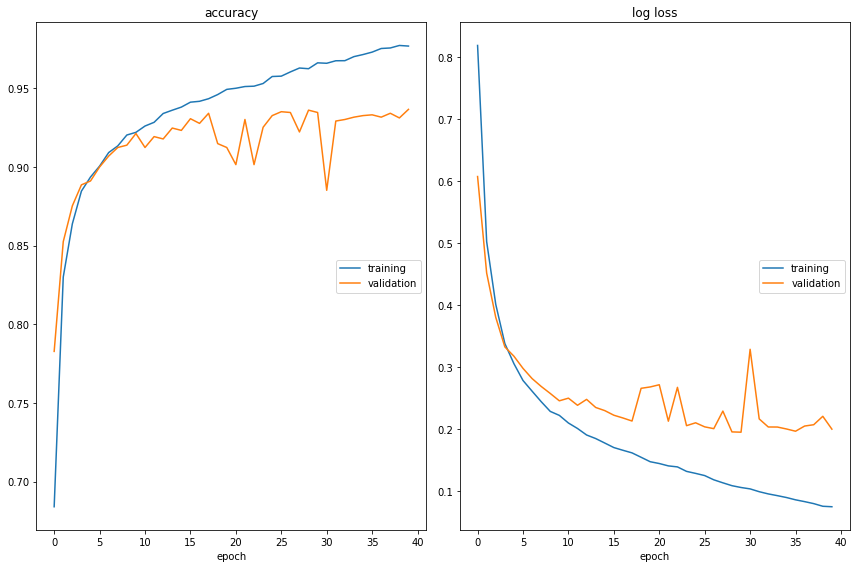

accuracy
	training         	 (min:    0.684, max:    0.977, cur:    0.977)
	validation       	 (min:    0.783, max:    0.937, cur:    0.937)
log loss
	training         	 (min:    0.075, max:    0.819, cur:    0.075)
	validation       	 (min:    0.195, max:    0.608, cur:    0.200)


In [ ]:
resnet18 = models.resnet18(pretrained=True).to(device)
fc_in = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in, 4).to(device)
print(resnet18.fc)

fname = "Resnet18_new.pth"

resnet18 = train_model(resnet18, batch_size = batch_size, lr=lr, 
                       momentum=momentum, weight_decay=weight_decay, 
                       n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

### Model 2

In [ ]:
# set hyperparamters
lr=1e-2
momentum=0.5
weight_decay=0
n_epochs=30
epoch_start = 0
batch_size = 32
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

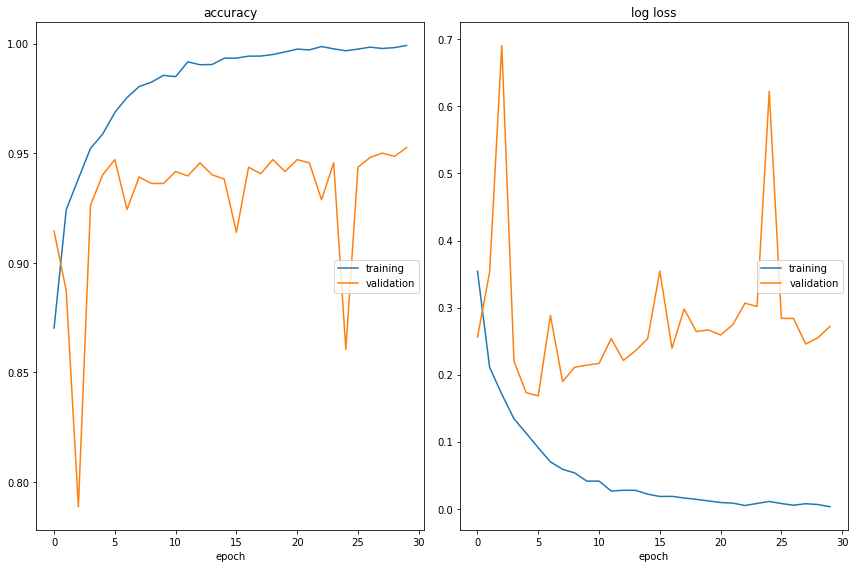

accuracy
	training         	 (min:    0.870, max:    0.999, cur:    0.999)
	validation       	 (min:    0.789, max:    0.952, cur:    0.952)
log loss
	training         	 (min:    0.003, max:    0.354, cur:    0.003)
	validation       	 (min:    0.168, max:    0.691, cur:    0.272)


In [ ]:
# load pretrained resnet18
resnet18 = models.resnet18(pretrained=True).to(device)
fc_in = resnet18.fc.in_features
# we alter the last layer of the resnet18 to 4, which matches the number of class in our classification task.
resnet18.fc = nn.Linear(fc_in, 4).to(device)
print(resnet18.fc)

resnet18 = train_model(resnet18, batch_size = batch_size, lr=lr, momentum=momentum, 
                       weight_decay=weight_decay, n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

### Model 3

In [ ]:
# set hyperparamters
lr=1e-3
momentum=0.5
weight_decay=1e-2
n_epochs=30
epoch_start = 0
batch_size = 64
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

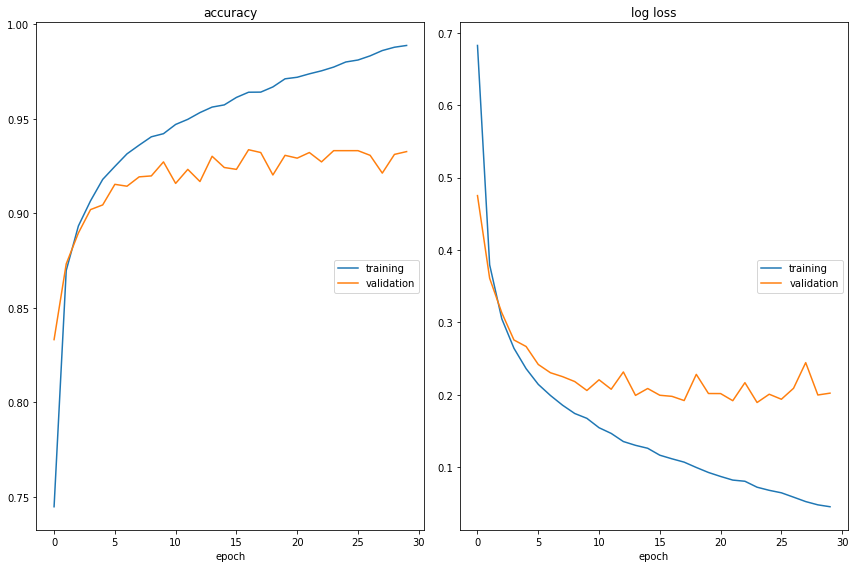

accuracy
	training         	 (min:    0.745, max:    0.989, cur:    0.989)
	validation       	 (min:    0.833, max:    0.934, cur:    0.933)
log loss
	training         	 (min:    0.045, max:    0.683, cur:    0.045)
	validation       	 (min:    0.189, max:    0.475, cur:    0.202)


In [ ]:
# load pretrained resnet18
resnet18_2 = models.resnet18(pretrained=True).to(device)
fc_in = resnet18_2.fc.in_features
# we alter the last layer of the resnet18_2 to 4, which matches the number of class in our classification task.
resnet18_2.fc = nn.Linear(fc_in, 4).to(device)
print(resnet18_2.fc)

resnet18_2 = train_model(resnet18_2, batch_size = batch_size, lr=lr, momentum=momentum, 
                         weight_decay=weight_decay, n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

## ResNet 34

### Model 1

In [ ]:
# set hyperparamters
lr=1e-3
momentum=0.5
weight_decay=1e-2
n_epochs = 50
epoch_start = 0
batch_size = 64
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

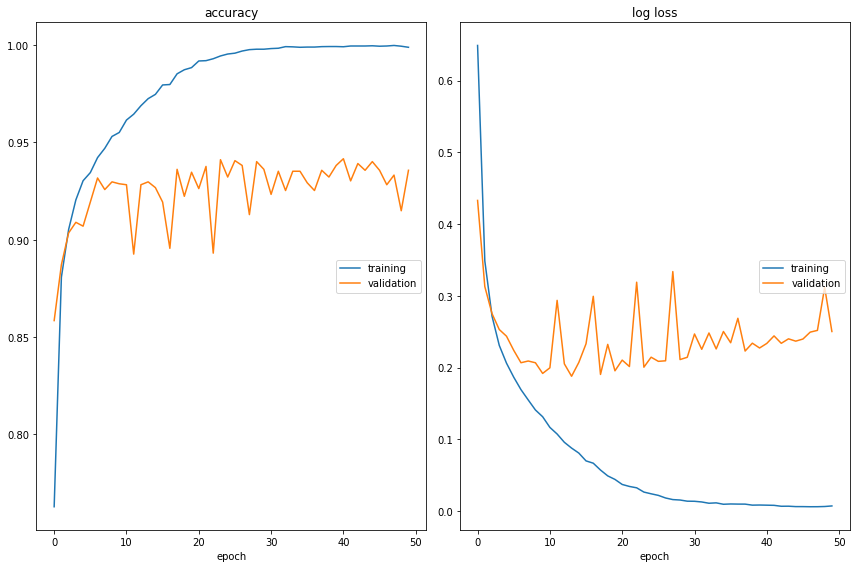

accuracy
	training         	 (min:    0.763, max:    1.000, cur:    0.999)
	validation       	 (min:    0.858, max:    0.942, cur:    0.936)
log loss
	training         	 (min:    0.006, max:    0.649, cur:    0.007)
	validation       	 (min:    0.188, max:    0.433, cur:    0.250)


In [ ]:
# load pretrained resnet34
resnet34 = models.resnet34(pretrained=True).to(device)
fc_in = resnet34.fc.in_features
# we alter the last layer of the resnet18_4 to 4, which matches the number of class in our classification task.
resnet34.fc = nn.Linear(fc_in, 4).to(device)
print(resnet34.fc)

resnet34 = train_model(resnet34, batch_size = batch_size, lr=lr, 
                       momentum=momentum, weight_decay=weight_decay, 
                       n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

### Model 2

In [ ]:
# set hyperparamters
lr=8e-5
momentum=0.5
weight_decay=1e-3
n_epochs = 40
epoch_start = 0
batch_size = 64
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

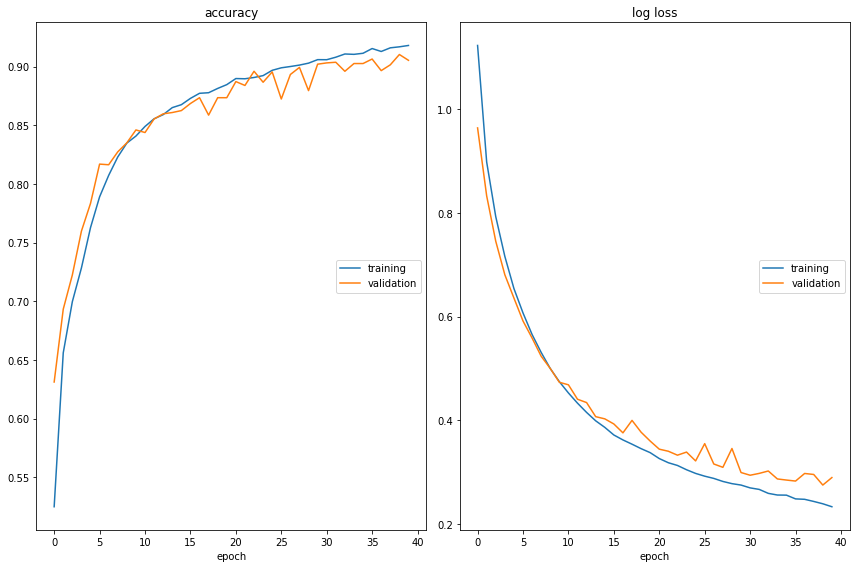

accuracy
	training         	 (min:    0.525, max:    0.918, cur:    0.918)
	validation       	 (min:    0.631, max:    0.910, cur:    0.905)
log loss
	training         	 (min:    0.233, max:    1.123, cur:    0.233)
	validation       	 (min:    0.275, max:    0.964, cur:    0.290)


In [ ]:
# load pretrained resnet34
resnet34 = models.resnet34(pretrained=True).to(device)
fc_in = resnet34.fc.in_features
# we alter the last layer of the resnet18_4 to 4, which matches the number of class in our classification task.
resnet34.fc = nn.Linear(fc_in, 4).to(device)
print(resnet34.fc)

resnet34 = train_model(resnet34, batch_size = batch_size, lr=lr, 
                       momentum=momentum, weight_decay=weight_decay, 
                       n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

### Model 3

In [ ]:
# set hyperparamters
lr=2e-4
momentum=0.5
weight_decay=0.1
n_epochs = 30
epoch_start = 0
batch_size = 64
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

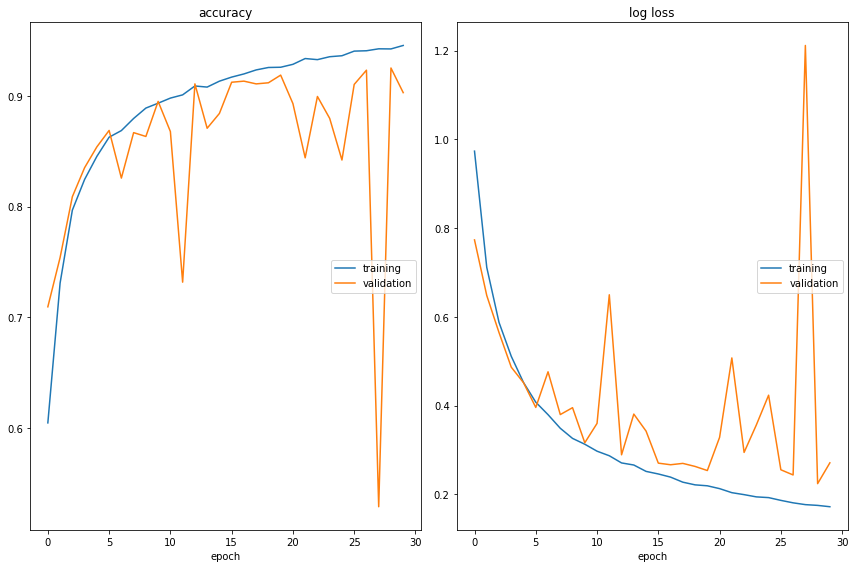

accuracy
	training         	 (min:    0.605, max:    0.946, cur:    0.946)
	validation       	 (min:    0.529, max:    0.925, cur:    0.903)
log loss
	training         	 (min:    0.172, max:    0.973, cur:    0.172)
	validation       	 (min:    0.224, max:    1.212, cur:    0.271)


In [ ]:
# load pretrained resnet34
resnet34 = models.resnet34(pretrained=True).to(device)
fc_in = resnet34.fc.in_features
# we alter the last layer of the resnet18_4 to 4, which matches the number of class in our classification task.
resnet34.fc = nn.Linear(fc_in, 4).to(device)
print(resnet34.fc)

resnet34 = train_model(resnet34, batch_size = batch_size, lr=lr, 
                       momentum=momentum, weight_decay=weight_decay, 
                       n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

## ResNet 50

### Model 1

In [ ]:
# set hyperparamters
lr=2e-5
momentum=0.5
weight_decay=3e-4
n_epochs=6
epoch_start = 0
batch_size = 32
accuracy_score_type = 'normal'
optimizer_type = 'Adam'
test_batch_size = 1000

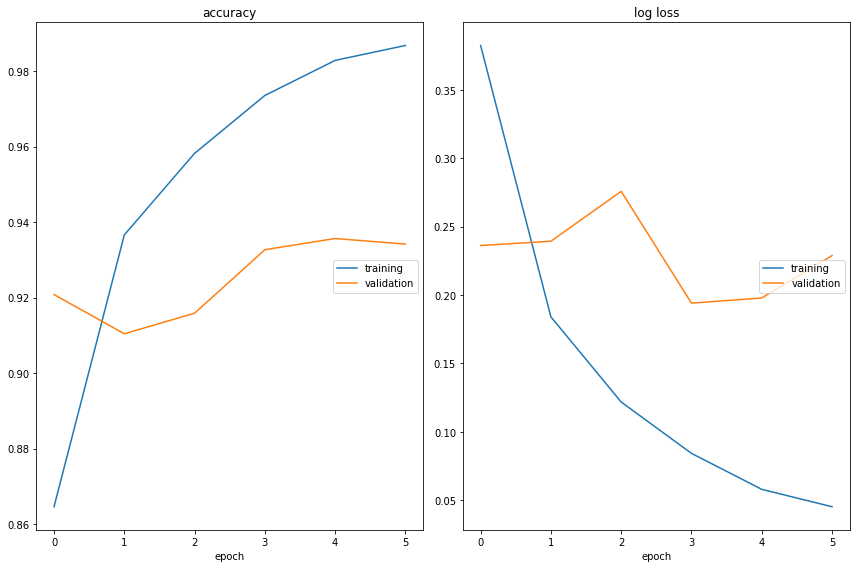

accuracy
	training         	 (min:    0.865, max:    0.987, cur:    0.987)
	validation       	 (min:    0.910, max:    0.936, cur:    0.934)
log loss
	training         	 (min:    0.045, max:    0.382, cur:    0.045)
	validation       	 (min:    0.194, max:    0.276, cur:    0.229)


In [ ]:
resnet50 = models.resnet50(pretrained=True).to(device)
fc_in = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_in, 4).to(device)
print(resnet50.fc)

reswide101 = train_model(resnet50, weight_decay=weight_decay, lr=lr, n_epochs=n_epochs, batch_size=batch_size, optimizer_type=optimizer_type)

### Model 2

In [ ]:
# set hyperparamters
lr=5e-5
momentum=0.5
weight_decay=3e-4
n_epochs=30
epoch_start = 0
batch_size = 32
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

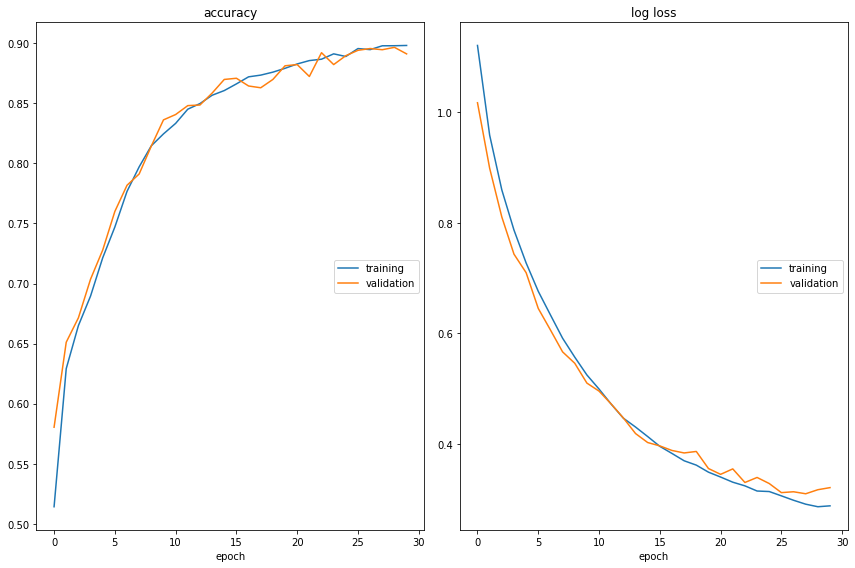

accuracy
	training         	 (min:    0.514, max:    0.898, cur:    0.898)
	validation       	 (min:    0.580, max:    0.897, cur:    0.891)
log loss
	training         	 (min:    0.286, max:    1.121, cur:    0.288)
	validation       	 (min:    0.310, max:    1.017, cur:    0.321)


In [ ]:
resnet50 = models.resnet50(pretrained=True).to(device)
fc_in = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_in, 4).to(device)
print(resnet50.fc)

fname = "Resnet50_lr5e-5_full.pth"

reswide101 = train_model(resnet50, weight_decay=weight_decay, lr=lr, n_epochs=n_epochs, batch_size=batch_size)

### Model 3

In [ ]:
# set hyperparamters
lr=8e-5
momentum=0.5
weight_decay=3e-4
n_epochs=30
epoch_start = 0
batch_size = 32
accuracy_score_type = 'normal'
optimizer_type = 'SGD'
test_batch_size = 1000

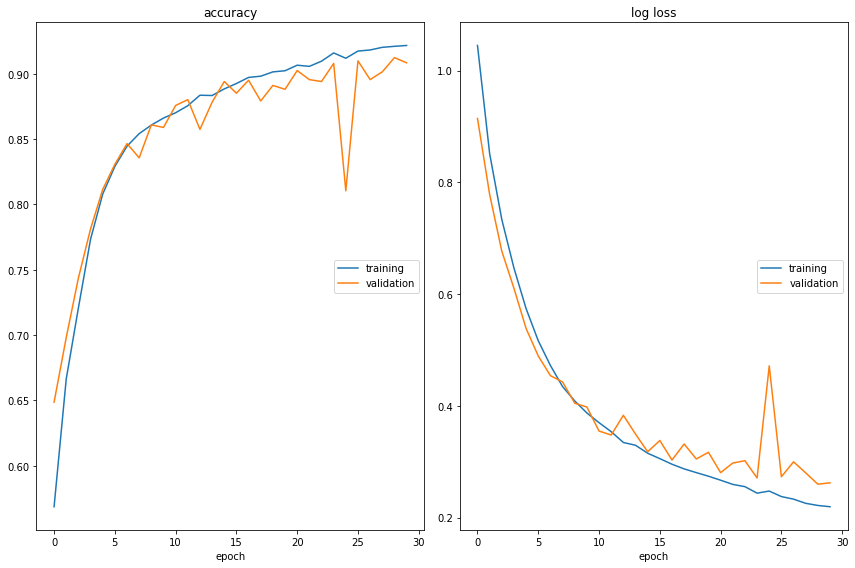

accuracy
	training         	 (min:    0.569, max:    0.922, cur:    0.922)
	validation       	 (min:    0.649, max:    0.912, cur:    0.908)
log loss
	training         	 (min:    0.220, max:    1.045, cur:    0.220)
	validation       	 (min:    0.260, max:    0.914, cur:    0.262)


In [ ]:
resnet50 = models.resnet50(pretrained=True).to(device)
fc_in = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_in, 4).to(device)
print(resnet50.fc)

reswide101 = train_model(resnet50, weight_decay=weight_decay, lr=lr, n_epochs=n_epochs, batch_size=batch_size)

Finally, we chose to give up ResNet50. Since it is more complicate than ResNet18 and ResNet34, so the batch size, the size of the picture, the size of the training set is by the GPU memory on Colab. We have tried to cut the picture to a smaller size but this may make us lose important edge information. As we can see the accuracy is hard to improve when reaching about 90%.